## Setup paths + load data

In [14]:
from pathlib import Path
import pandas as pd

# Repo root (same pattern)
here = Path.cwd()
REPO_ROOT = next(p for p in [here, *here.parents] if (p / ".git").exists())

PROCESSED = REPO_ROOT / "data" / "processed"
FIGURES = REPO_ROOT / "reports" / "figures"
FIGURES.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT :", REPO_ROOT)
print("PROCESSED:", PROCESSED)
print("FIGURES  :", FIGURES)

# Load processed data
csv_f = PROCESSED / "weather_lju_processed.csv"
df = pd.read_csv(csv_f, parse_dates=["time"])
df.head()


REPO_ROOT : C:\Users\Mihah\PyCharmProjects\data_prototype
PROCESSED: C:\Users\Mihah\PyCharmProjects\data_prototype\data\processed
FIGURES  : C:\Users\Mihah\PyCharmProjects\data_prototype\reports\figures


,time,temp_c,rh,date,hour,anomaly
0,2025-11-11 00:00:00,2.3,100,2025-11-11,0,1
1,2025-11-11 01:00:00,2.2,100,2025-11-11,1,1
2,2025-11-11 02:00:00,1.6,100,2025-11-11,2,1
3,2025-11-11 03:00:00,0.6,100,2025-11-11,3,-1
4,2025-11-11 04:00:00,1.2,99,2025-11-11,4,-1


## Isolation forest anomalies (first version)

In [15]:
from sklearn.ensemble import IsolationForest

features = df[["temp_c", "rh"]]  # basic 2D feature space

iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # ~5% anomalies
    random_state=42
)

df["anomaly_score"] = iso.fit_predict(features)   # -1 = anomaly, 1 = normal
df["is_anomaly"] = df["anomaly_score"] == -1

df["is_anomaly"].value_counts()


is_anomaly
False    205
True      11
Name: count, dtype: int64

## Visualise anomalies & save plot

WindowsPath('C:/Users/Mihah/PyCharmProjects/data_prototype/reports/figures/temp_anomalies.png')

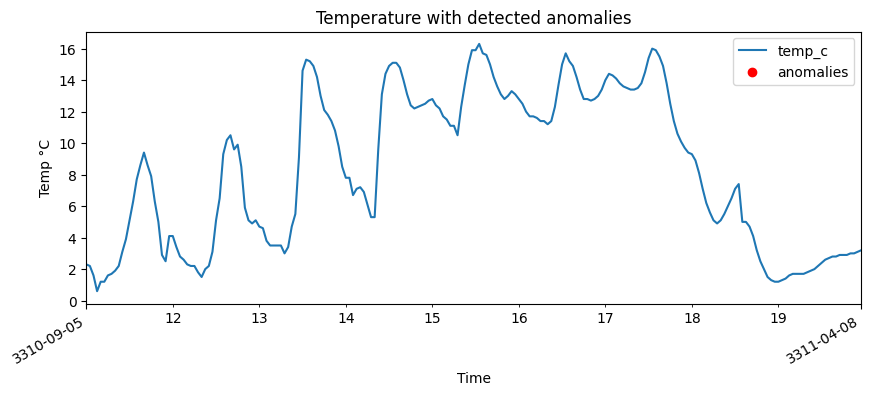

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 4))

# 1) Plot the full temp series — this already handles datetime correctly
df.plot(x="time", y="temp_c", ax=ax, label="temp_c")

# 2) Select anomalies
anom = df[df["is_anomaly"]]

# 3) Convert anomaly timestamps for scatter
x_anom = mdates.date2num(anom["time"])

# 4) Scatter anomalies (no need for ax.xaxis_date())
ax.scatter(x_anom, anom["temp_c"], color="red", label="anomalies", zorder=5)

# 5) Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

ax.set_title("Temperature with detected anomalies")
ax.set_xlabel("Time")
ax.set_ylabel("Temp °C")
ax.legend()

out_f = FIGURES / "temp_anomalies.png"
fig.savefig(out_f, dpi=150, bbox_inches="tight")
out_f


## Save anomalies as a separate CSV

In [17]:
anoms_f = PROCESSED / "weather_lju_anomalies.csv"
df[df["is_anomaly"]].to_csv(anoms_f, index=False)
anoms_f, anoms_f.exists()


(WindowsPath('C:/Users/Mihah/PyCharmProjects/data_prototype/data/processed/weather_lju_anomalies.csv'),
 True)